## Project 2: Listen Local

For project #2, my goal was to scrape data from a website with concert information, and use that information to create lists of bands playing at a particular venue.


<img src="listenlocalimage.png" width="125" height="125" />


##### Why this project?

Most people like music, and enjoy seeing it live. Personally, I would be more likely to see a band at a local venue if I had an easy way to screen local acts by listening to their music beforehand. However, I do want to put in the time to manually create playlists of local acts in order to screen for bands I enjoy.



### Songkick.com

![alt text](songkick.png "Songkick Website")


## Web Scraping

![alt text](scrapylogo.png "...fast, simple, yet extensible...")

Results: 15,000 scheduled concerts

## Data Cleaning

![alt text](cleaneddata.png "Cleaned Data")

# EDA

In [1]:
import spotipy
import spotipy.util as util
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import re
%matplotlib inline

In [2]:
concerts = pd.read_csv("concerts_clean.csv", index_col=0)
concerts['date'] = pd.to_datetime(concerts['date'], format = "%Y/%m/%d")

In [3]:
concerts.head()

,date,url,venue,artist,location,time
0,2017-02-02,https://www.songkick.com/metro_areas/7644-us-n...,Knitting Factory,Don Giovanni Records Showcase 2017,new-york,NaN
1,2017-02-03,https://www.songkick.com/metro_areas/7644-us-n...,Madison Square Garden,The Lumineers,new-york,NaN
2,2017-02-03,https://www.songkick.com/metro_areas/7644-us-n...,Terminal 5,AFI,new-york,19:00:00-0500
3,2017-02-03,https://www.songkick.com/metro_areas/7644-us-n...,Webster Hall,Keys N Krates (DJ set),new-york,22:00:00-0500
4,2017-02-03,https://www.songkick.com/metro_areas/7644-us-n...,Music Hall of Williamsburg,Bear's Den,new-york,20:00:00-0500


In [4]:
cityview = concerts.groupby('location')

In [28]:
cityview.describe()[0:6]

month
location                  
atlanta  count  950.000000
         mean     3.157895
         std      1.275660
         min      2.000000
         25%      2.000000
         50%      3.000000

In [46]:
sns.set()
sns.set(font_scale=1.15)


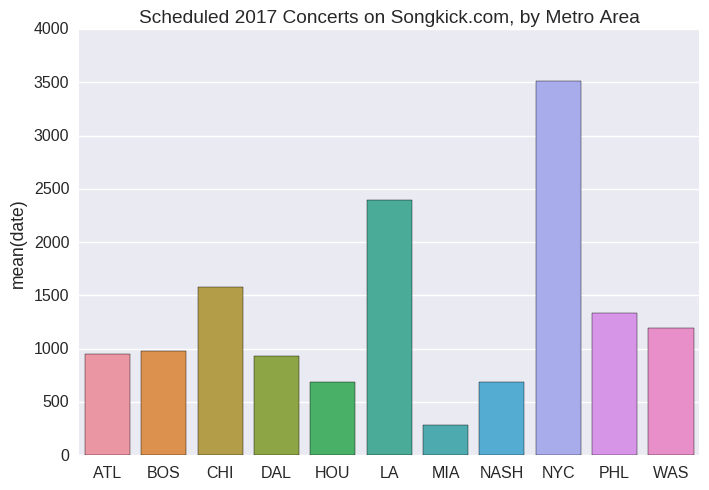

In [51]:
city_names = ['ATL', 'BOS', 'CHI', 'DAL', 'HOU', 'LA', 'MIA', "NASH", 'NYC', 'PHL', 'WAS']

sns.barplot(x=city_names, y=cityview.count()['date'])
sns.plt.title('Scheduled 2017 Concerts on Songkick.com, by Metro Area')


In [31]:
month = []
for x in concerts['date']:
    month.append(x.month)
concerts['month'] = month

month_names = ['Febuary', 'March', 'April', 'May', 'June', 'July', \
               'August', 'September', 'October', 'November', 'December']

In [32]:
monthview = concerts.groupby('month')
scheduled_shows = monthview.count().sort_values(by='date', ascending=False)[0:11]

[None, None, None, None, None, None, None, None, None, None, None]

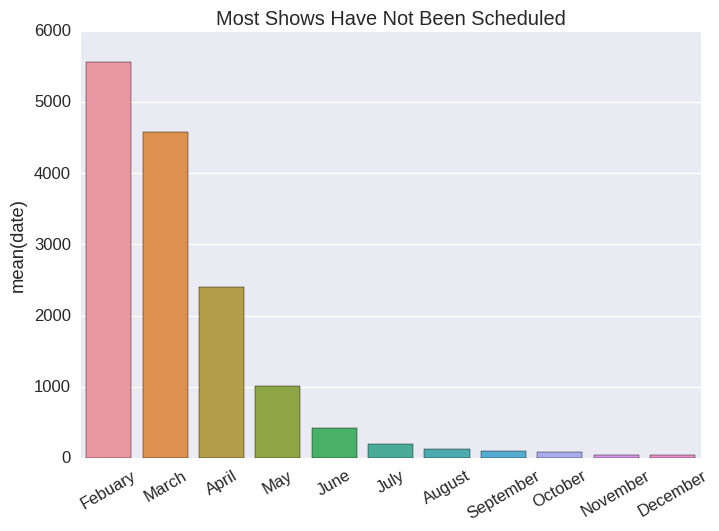

In [33]:
mon = sns.barplot(x=month_names, y=scheduled_shows['date'])
sns.plt.title('Most Shows Have Not Been Scheduled')
sns.plt.setp(mon.get_xticklabels(), rotation=30)

In [34]:
venueview = concerts.groupby('venue')
top_venues = venueview.count().sort_values(by='date', ascending=False)[0:10]

In [35]:
top_venues.index
top_venue_names = ['House of Blues', 'Birdland', "Eddie's Attic",
       "B.B. King's", 'Rockwood Music Hall', 'Jazz Standard', 'Jammin Java',
       'Brooklyn Bowl','The Bowery Electric','Mercury Lounge']

[None, None, None, None, None, None, None, None, None, None]

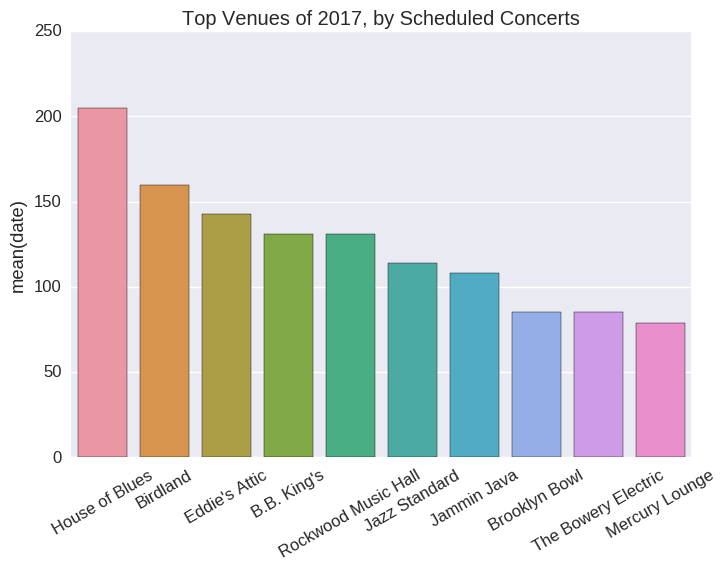

In [36]:
ven = sns.barplot(x=top_venue_names, y=top_venues['date'])
sns.plt.title('Top Venues of 2017, by Scheduled Concerts')
plt.setp(ven.get_xticklabels(), rotation=30)

In [37]:
artists = concerts.groupby('artist')
top_artists = artists.count().sort_values(by='date', ascending=False)[0:10]

In [52]:
top_artists_names = ['B.B. King All Stars', 'DJ Bobby B',
       'Jeffrey Scott Stewart', 'Mingus Big Band',
       'Reverend Vince Anderson',
       'The Fresh Kids of Bel-Air', 'Rocknoceros',
       'Van Darien', 'Sandra Dean', 'Marcus Terell & the Serenades']

[None, None, None, None, None, None, None, None, None, None]

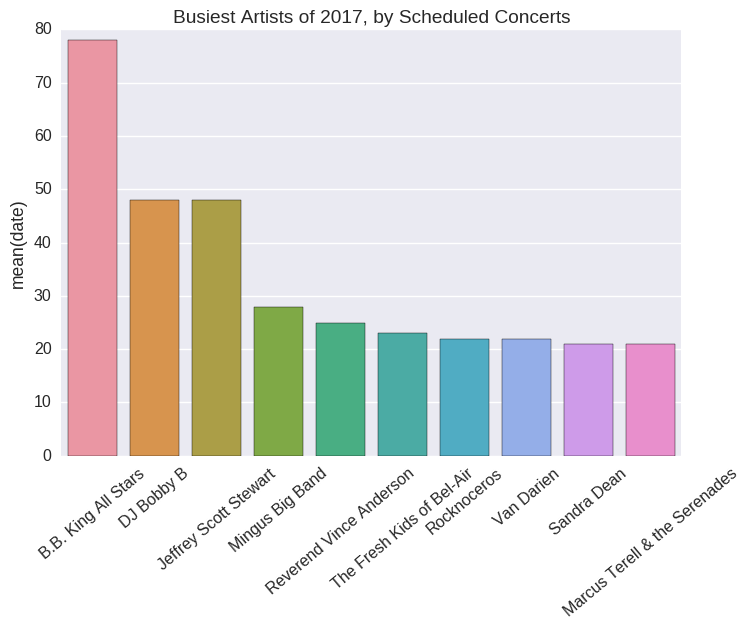

In [53]:
art = sns.barplot(x=top_artists_names, y=top_artists['date'])
sns.plt.title('Busiest Artists of 2017, by Scheduled Concerts')
plt.setp(art.get_xticklabels(), rotation=40)

## Creating a Spotify Playlist

#### First, use our scraped data to get a list of concerts at a venue over a given time period...

In [1]:
def get_venue_artists(venue, start_date = "2017-01-01", end_date = "2017-12-31"):
    concert_dates = pd.date_range(start = start_date, end = end_date, freq = 'D')
    artists = []
    for show in concerts.loc[concerts['venue'] == venue, ['date', 'artist']].itertuples():
        if show[1] in concert_dates:
            artists.append(show)
    return artists

### Use Spotipy library to match artists playing at a venue to Spotify Artist IDs

In [2]:
#NOTE: I would like to add a way to validate the artist returned by the search here. To do later...
def get_artist_ids(artists):
    sp = spotipy.Spotify()
    artist_plus_ids = []
    for artist in artists:
        search = sp.search(q=artist, type = 'artist', limit = 1)
        try:
            artist_plus_ids.append((search['artists']['items'][0]['name'] ,  search['artists']['items'][0]['id']))
        except IndexError:
            pass
    return artist_plus_ids

In [3]:
def get_venue_artist_ids(venue, start_date = "2017-01-01", end_date = "2017-12-31"):
    sp = spotipy.Spotify()
    artists = get_venue_artists(venue, start_date, end_date)
    artist_plus_ids = []
    for artist in artists:
        search = sp.search(q=artist[2], type = 'artist', limit = 1)
        try:
            artist_plus_ids.append((search['artists']['items'][0]['name'] ,  search['artists']['items'][0]['id']))
        except IndexError:
            pass
    return artist_plus_ids


### Use Spotipy library to get top tracks from artists, according to Spotify Artist IDs acquired in previous step

In [4]:
def create_venue_songlist(venue, start_date = "2017-01-01", end_date = "2017-12-31"):
    sp = spotipy.Spotify()
    songlist = []
    for artist in get_venue_artist_ids(venue, start_date, end_date):
        artist_tracks = sp.artist_top_tracks(artist[1])['tracks']
        if len(artist_tracks) >= 5:
            for track in range(0, 5):
                songlist.append((artist_tracks[track]['name'], \
                                 artist_tracks[track]['id']))
    return songlist
    

Note: Sets vs Lists

In [5]:
def prepare_song_id_list(songlist):
    song_ids = []
    for song in songlist:
        song_ids.append(str(song[1]))
    return song_ids

In [6]:
def create_venue_songlist_ids(venue, start_date = "2017-01-01", end_date = "2017-12-31"):
    songlist = create_venue_songlist(venue, start_date, end_date)
    print type(songlist)
    if len(songlist) >= 100:
        songlist = songlist[0:99]
    ptitle = ("%s from %s to %s") % (venue, start_date, end_date)
    return (ptitle, prepare_song_id_list(songlist))

### Now that we have a list of song IDs, let's authenticate a spotify login, and create a playlist

![alt text](spotifywebdev.png "Registering an app was suprisingly easy")

In [7]:
SPOTIPY_CLIENT_ID = '1723f7534a1c4cde9efe16b0b2753d7f'
SPOTIPY_CLIENT_SECRET = 'e3e4b35b367a430c8b2900ef5d6165a7'
SPOTIPY_REDIRECT_URI = 'http://localhost:8888'

In [8]:
token = util.prompt_for_user_token("", 'playlist-modify-public', SPOTIPY_CLIENT_ID, SPOTIPY_CLIENT_SECRET, SPOTIPY_REDIRECT_URI)

NameError: name 'util' is not defined

In [62]:
username = 'afeierman'
playlist_prepped = create_venue_songlist_ids("Madison Square Garden", '2017-04-01', '2017-05-01')
playlist_title = playlist_prepped[0]
track_ids = playlist_prepped[1]

<type 'list'>


In [63]:
print type(token)
print token

<type 'unicode'>
BQDxIbzHDhpvznhDgpIrCiRtGuCJk4CbRMDVjDskKV96q0vJC7i5YxxCXyEBKh5o1mEAuLQ4fcMqGx_RpWA59jdrOIUzz2GFg1xFt7OmebVpOCGHOowplUHRNqq3MXU81YHOg3wKdL-El5-rMK36IdnF1COlOObgXyUbb8fSCK7xfOU7F_94ZEmraC1cGgawxMj06Rr5F9DndwtcfvDyUUznniHfGZr4wWp_1VjVUDk9hA


### If everything works correctly, the code below creates a Spotify playlist

In [ ]:
if token:
    sp = spotipy.Spotify(auth=token)
    sp.trace = False #Not sure if this is needed
    sp.user_playlist_create(username, playlist_title)
    playlists = sp.user_playlists(username)
    for playlist in playlists['items']:
        if playlist['name'] == playlist_title:
            playlist_id = playlist['id']
            break
    results = sp.user_playlist_add_tracks(username, playlist_id, track_ids)
    print results
else:
    print "Can't get token"

In [ ]:
# ![alt text](spottyplaylist.png "Display Spotify Playlist")

![alt text](ll2.png "and PythonAnywhere")

## [afeierman.pythonanywhere.com](afeierman.pythonanywhere.com)